In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [5]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
x_val = x_test[:7000]
x_test = x_test[7000:]

In [7]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


#### Add noise

In [8]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [9]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

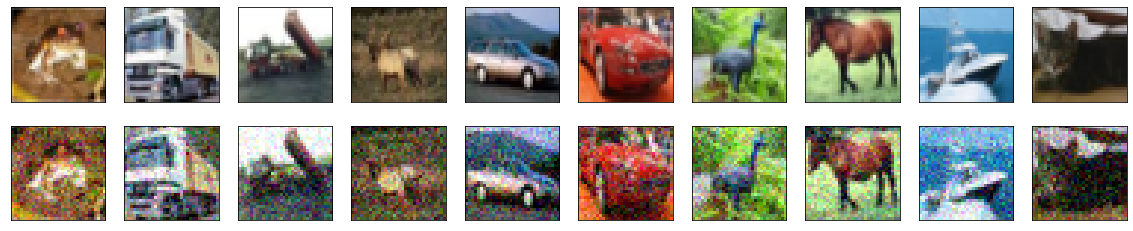

In [10]:
showOrigDec(x_train, x_train_noisy)

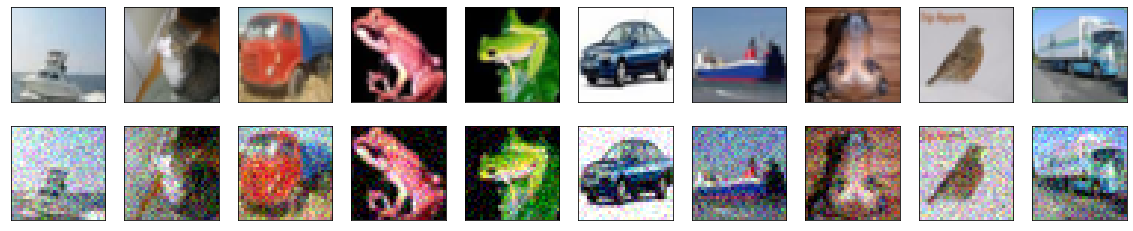

In [11]:
showOrigDec(x_train[100:], x_train_noisy[100:])

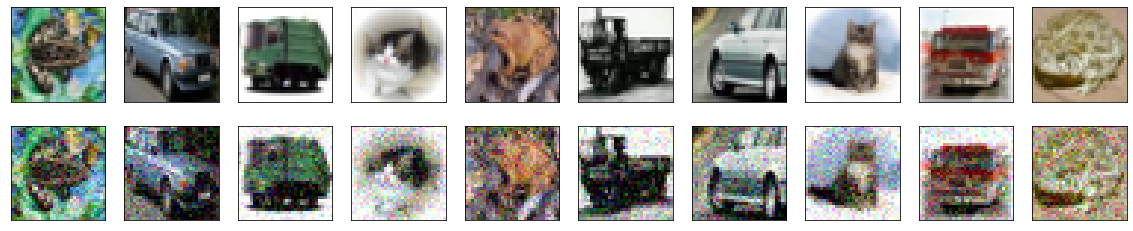

In [12]:
showOrigDec(x_train[200:], x_train_noisy[200:])

#### Convolution encoder and noisy

In [13]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [14]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
#model.load_weights(saveDir + "AutoEncoder.hdf5")

In [16]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_denoise_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [17]:
history = model.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val_noisy, x_val),
                    shuffle=True)

Train on 50000 samples, validate on 7000 samples
Epoch 1/10
50000/50000 [==============================] - 129s 3ms/step - loss: 0.5676 - val_loss: 0.5621
Epoch 2/10
50000/50000 [==============================] - 133s 3ms/step - loss: 0.5617 - val_loss: 0.5599
Epoch 3/10
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5602 - val_loss: 0.5588
Epoch 4/10
50000/50000 [==============================] - 126s 3ms/step - loss: 0.5590 - val_loss: 0.5578
Epoch 5/10
50000/50000 [==============================] - 130s 3ms/step - loss: 0.5585 - val_loss: 0.5573
Epoch 6/10
50000/50000 [==============================] - 131s 3ms/step - loss: 0.5579 - val_loss: 0.5568
Epoch 7/10
50000/50000 [==============================] - 134s 3ms/step - loss: 0.5576 - val_loss: 0.5569
Epoch 8/10
50000/50000 [==============================] - 149s 3ms/step - loss: 0.5574 - val_loss: 0.5565
Epoch 9/10
50000/50000 [==============================] - 132s 3ms/step - loss: 0.5571 - val_loss: 0.55

In [18]:
score = model.evaluate(x_test_noisy, x_test, verbose=1)
print(score)

3000/3000 [==============================] - 2s 800us/step
0.5555501141548157


#### VIsualize original and noisy

In [19]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)

In [20]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 0.4670110046863556
Cifar10_val: 0.47036585211753845


In [21]:
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

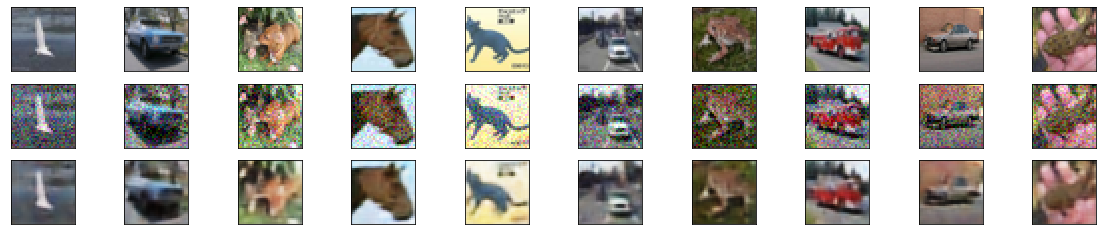

In [22]:
showOrigDec(x_test, x_test_noisy, c10test)